# tinyBERT Fine-tuning on LIAR2 Dataset
# Based on EDA findings

In this notebook, I'm implementing a fake news detection model using tinyBERT and the LIAR2 dataset. I'll enhance the model with additional features based on my EDA findings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import random
import os
import warnings
import re
warnings.filterwarnings('ignore')

## Environment Setup

First, I'll set up reproducibility and check for GPU availability.

In [2]:
# Set seed for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    
set_seed(42)

In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Exploration

Let's load the LIAR2 dataset splits and examine the class distribution to understand our classification task.

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/valid.csv
/kaggle/input/train.csv
/kaggle/input/test.csv


In [5]:
# Load the datasets
print("Loading datasets...")
train_df = pd.read_csv('/kaggle/input/train.csv')
valid_df = pd.read_csv('/kaggle/input/valid.csv')
test_df = pd.read_csv('/kaggle/input/test.csv')

print(f"Training set shape: {train_df.shape}")
print(f"Validation set shape: {valid_df.shape}")
print(f"Testing set shape: {test_df.shape}")

Loading datasets...
Training set shape: (18369, 16)
Validation set shape: (2297, 16)
Testing set shape: (2296, 16)


In [6]:
# Display the class distribution
print("\nClass distribution in training set:")
print(train_df['label'].value_counts().sort_index())


Class distribution in training set:
label
0    2425
1    5284
2    2882
3    2967
4    2743
5    2068
Name: count, dtype: int64


## Label Mapping

The LIAR2 dataset uses numerical labels 0-5. I'll create a mapping to make them more interpretable and visualize the class distribution.

In [7]:
# Define a mapping for the labels
label_mapping = {
    0: "pants_on_fire",
    1: "false",
    2: "mostly_false",
    3: "half_true",
    4: "mostly_true",
    5: "true"
}

In [8]:
print("\nLabel mapping:")
for key, value in label_mapping.items():
    print(f"{key}: {value}")


Label mapping:
0: pants_on_fire
1: false
2: mostly_false
3: half_true
4: mostly_true
5: true


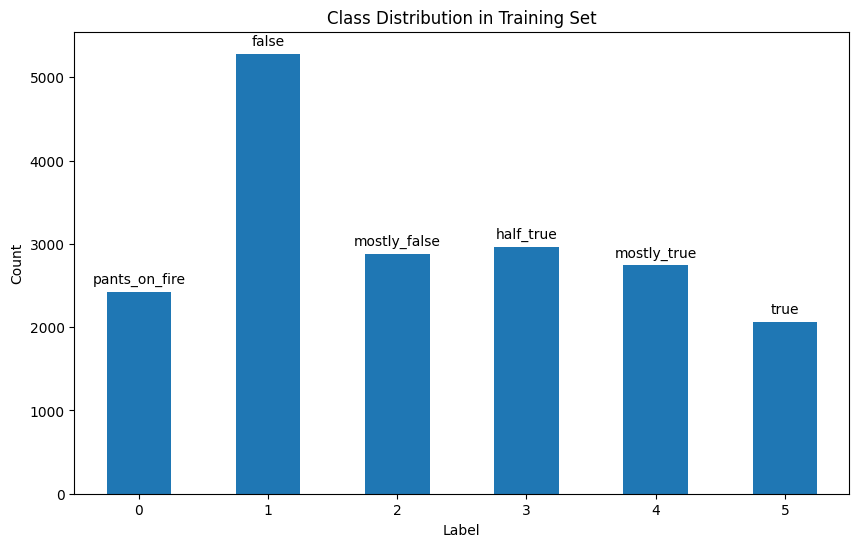

In [9]:
# Plot class distribution
plt.figure(figsize=(10, 6))
train_df['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Class Distribution in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
for i, count in enumerate(train_df['label'].value_counts().sort_index()):
    plt.text(i, count + 100, label_mapping[i], ha='center')
plt.show()

## Handling Class Imbalance

The dataset is imbalanced with more samples in the "false" category and fewer in "pants_on_fire" and "true" categories. I'll calculate class weights to help balance the training.

In [10]:
# Calculate class weights to handle imbalance
class_counts = train_df['label'].value_counts().sort_index()
total_samples = len(train_df)
class_weights = {}
for label, count in class_counts.items():
    class_weights[label] = total_samples / (len(class_counts) * count)

In [11]:
print("\nClass weights to handle imbalance:")
for label, weight in class_weights.items():
    print(f"{label} ({label_mapping[label]}): {weight:.4f}")


Class weights to handle imbalance:
0 (pants_on_fire): 1.2625
1 (false): 0.5794
2 (mostly_false): 1.0623
3 (half_true): 1.0319
4 (mostly_true): 1.1161
5 (true): 1.4804


## Feature Engineering

Based on my EDA findings, I'll combine the statement with metadata using special separators to help the model distinguish between different types of information.

In [12]:
# Create a combined feature from metadata as suggested in the EDA
# Enhanced feature combination function with special separators
def combine_features(row):
    # Clean statement
    statement = re.sub(r'http\S+', '[URL]', str(row['statement']))
    
    # Process metadata
    subject = str(row['subject']) if pd.notna(row['subject']) else "unknown"
    speaker = str(row['speaker']) if pd.notna(row['speaker']) else "unknown"
    context = str(row['context']) if pd.notna(row['context']) else "unknown"
    
    # More distinctive formatting with TYPE markers
    combined = f"{statement} [SEP] [SUBJ] {subject} [SEP] [SPKR] {speaker} [SEP] [CTXT] {context}"
    return combined

In [13]:
# Apply the feature combination
print("\nCombining features...")
train_df['combined_text'] = train_df.apply(combine_features, axis=1)
valid_df['combined_text'] = valid_df.apply(combine_features, axis=1)
test_df['combined_text'] = test_df.apply(combine_features, axis=1)

# Sample of combined text
print("\nSample of combined text:")
print(train_df['combined_text'].iloc[0])


Combining features...

Sample of combined text:
90 percent of Americans "support universal background checks" for gun purchases. [SEP] [SUBJ] government regulation;polls and public opinion;guns [SEP] [SPKR] chris abele [SEP] [CTXT] a tweet


## Text Processing and Tokenization

Now I'll tokenize the text using tinyBERT's tokenizer. I'm using a max sequence length of 192 tokens to capture more context from the statements and metadata.

In [14]:
# Load the TinyBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')

config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [15]:
# Set the maximum sequence length
# Increase sequence length
MAX_LEN = 192

In [16]:
# Tokenize the data
def tokenize_data(texts, labels, max_len=MAX_LEN):
    input_ids = []
    attention_masks = []
    
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text=text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    # Convert lists to tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    
    return input_ids, attention_masks, labels

In [17]:
print("Tokenizing data...")
# Tokenize training data
train_input_ids, train_attention_masks, train_labels = tokenize_data(
    train_df['combined_text'].tolist(), 
    train_df['label'].tolist()
)

# Tokenize validation data
val_input_ids, val_attention_masks, val_labels = tokenize_data(
    valid_df['combined_text'].tolist(), 
    valid_df['label'].tolist()
)

# Tokenize test data
test_input_ids, test_attention_masks, test_labels = tokenize_data(
    test_df['combined_text'].tolist(), 
    test_df['label'].tolist()
)
print("Done")

Tokenizing data...
Done


## Processing Justification Data

Some entries contain justification text that explains why a claim was rated true/false. This additional context might help the model make better decisions, so I'll process it separately.

In [18]:
# Process justification separately if available in your dataset
print("Processing justification data separately...")
if 'justification' in train_df.columns:
    # Clean justification text
    train_df['justification_clean'] = train_df['justification'].apply(
        lambda x: re.sub(r'http\S+', '[URL]', str(x)) if pd.notna(x) else "")
    valid_df['justification_clean'] = valid_df['justification'].apply(
        lambda x: re.sub(r'http\S+', '[URL]', str(x)) if pd.notna(x) else "")
    test_df['justification_clean'] = test_df['justification'].apply(
        lambda x: re.sub(r'http\S+', '[URL]', str(x)) if pd.notna(x) else "")
    
    # Tokenize justification data
    train_just_ids, train_just_masks, _ = tokenize_data(
        train_df['justification_clean'].tolist(), 
        train_df['label'].tolist()
    )
    
    val_just_ids, val_just_masks, _ = tokenize_data(
        valid_df['justification_clean'].tolist(), 
        valid_df['label'].tolist()
    )
    
    test_just_ids, test_just_masks, _ = tokenize_data(
        test_df['justification_clean'].tolist(), 
        test_df['label'].tolist()
    )
    
    # Create combined datasets with both main text and justification
    train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_just_ids, train_just_masks, train_labels)
    val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_just_ids, val_just_masks, val_labels)
    test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_just_ids, test_just_masks, test_labels)
    
    print("Justification data prepared")
else:
    print("Justification data not found in dataset")
    train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
    val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
    test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

Processing justification data separately...
Justification data prepared


## Numerical Credibility Features

The dataset contains numerical features about speakers' credibility history. These count-based features could provide valuable signals about speaker reliability.

In [19]:
# Process numerical features (credibility history)
print("Processing numerical credibility features...")
numerical_columns = [col for col in train_df.columns if 'count' in col]

if numerical_columns:
    # Extract numerical features
    train_numerical = torch.tensor(train_df[numerical_columns].fillna(0).values, dtype=torch.float32)
    val_numerical = torch.tensor(valid_df[numerical_columns].fillna(0).values, dtype=torch.float32)
    test_numerical = torch.tensor(test_df[numerical_columns].fillna(0).values, dtype=torch.float32)
    
    # Update datasets to include numerical features
    if 'justification' in train_df.columns:
        train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_just_ids, train_just_masks, train_numerical, train_labels)
        val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_just_ids, val_just_masks, val_numerical, val_labels)
        test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_just_ids, test_just_masks, test_numerical, test_labels)
    else:
        train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_numerical, train_labels)
        val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_numerical, val_labels)
        test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_numerical, test_labels)
    
    print(f"Numerical features extracted: {numerical_columns}")
else:
    print("No numerical credibility features found")
    train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
    val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
    test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

Processing numerical credibility features...
Numerical features extracted: ['true_counts', 'mostly_true_counts', 'half_true_counts', 'mostly_false_counts', 'false_counts', 'pants_on_fire_counts']


## Creating PyTorch DataLoaders

Now I'll set up DataLoaders with batch size 32 for efficient training with random sampling for the training set and sequential sampling for validation and test sets.

In [20]:
# Create DataLoaders
batch_size = 32

# Create samplers and dataloaders with the proper enhanced datasets
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

In [21]:
print(f"Train dataset: {len(train_dataset)} samples")
print(f"Validation dataset: {len(val_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")

Train dataset: 18369 samples
Validation dataset: 2297 samples
Test dataset: 2296 samples


## Enhanced Model Architecture

I'm creating a custom model that extends DistilBERT with multiple pathways:
1. Main content pathway using DistilBERT
2. Justification text pathway (if available)
3. Numerical features pathway with dedicated layers
4. Combined features classifier

This architecture allows the model to leverage all available information sources.

In [22]:
class EnhancedTinyBertForFakeNews(torch.nn.Module):
    def __init__(self, num_labels=6, dropout_rate=0.3):
        super(EnhancedTinyBertForFakeNews, self).__init__()
        
        # Main content TinyBERT
        self.tinybert = AutoModelForSequenceClassification.from_pretrained(
            'huawei-noah/TinyBERT_General_4L_312D', 
            num_labels=num_labels,
            output_attentions=False,
            output_hidden_states=True,  # Get hidden states for feature extraction
        )
        
        # Increase dropout
        self.tinybert.dropout.p = dropout_rate
        
        # Check if justification and numerical features are available
        self.has_justification = 'justification' in train_df.columns
        self.has_numerical = len([col for col in train_df.columns if 'count' in col]) > 0
        
        # TinyBERT hidden size is 312 instead of 768
        self.hidden_size = 312
        
        # Justification pathway (optional)
        if self.has_justification:
            self.justification_bert = AutoModelForSequenceClassification.from_pretrained(
                'huawei-noah/TinyBERT_General_4L_312D', 
                num_labels=num_labels,
                output_attentions=False,
                output_hidden_states=True,
            )
            self.justification_bert.dropout.p = dropout_rate
        
        # Numerical features pathway (optional)
        if self.has_numerical:
            num_numerical_features = len([col for col in train_df.columns if 'count' in col])
            self.numerical_linear1 = torch.nn.Linear(num_numerical_features, 64)
            self.numerical_activation = torch.nn.ReLU()
            self.numerical_dropout = torch.nn.Dropout(dropout_rate)
            self.numerical_linear2 = torch.nn.Linear(64, 32)
            
            # Simple fuzzy-inspired layer for numerical features
            self.fuzzy_layer = torch.nn.Linear(32, num_labels)
            self.softmax = torch.nn.Softmax(dim=1)
        
        # Final classification layer - adjusted for TinyBERT's hidden size
        input_size = self.hidden_size  # TinyBERT hidden size
        if self.has_justification:
            input_size += self.hidden_size
        if self.has_numerical:
            input_size += 32
        
        self.classifier = torch.nn.Linear(input_size, num_labels)
    
    def forward(self, input_ids=None, attention_mask=None, just_ids=None, just_mask=None, 
                numerical_features=None, labels=None):
        
        # Process main content
        main_outputs = self.tinybert(input_ids, attention_mask=attention_mask, labels=None)
        main_features = main_outputs.hidden_states[-1][:, 0, :]  # Use CLS token
        
        # Process justification if available
        if self.has_justification and just_ids is not None:
            just_outputs = self.justification_bert(just_ids, attention_mask=just_mask, labels=None)
            just_features = just_outputs.hidden_states[-1][:, 0, :]
        else:
            just_features = None
        
        # Process numerical features if available
        if self.has_numerical and numerical_features is not None:
            num_hidden = self.numerical_linear1(numerical_features)
            num_hidden = self.numerical_activation(num_hidden)
            num_hidden = self.numerical_dropout(num_hidden)
            num_features = self.numerical_linear2(num_hidden)
            
            # Fuzzy-inspired outputs
            fuzzy_outputs = self.softmax(self.fuzzy_layer(num_features))
        else:
            num_features = None
            fuzzy_outputs = None
        
        # Combine features
        combined_features = main_features
        if just_features is not None:
            combined_features = torch.cat([combined_features, just_features], dim=1)
        if num_features is not None:
            combined_features = torch.cat([combined_features, num_features], dim=1)
        
        # Final classification
        logits = self.classifier(combined_features)
        
        # Calculate loss if labels provided
        loss = None
        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
            loss = loss_fct(logits, labels)
        
        return {"loss": loss, "logits": logits, "fuzzy_outputs": fuzzy_outputs}

In [23]:
# Instantiate the model
model = EnhancedTinyBertForFakeNews(num_labels=6, dropout_rate=0.3)

2025-05-05 05:20:10.378184: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746422410.644938      84 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746422410.717483      84 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
model = model.to(device)

model.safetensors:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

## Optimizer and Learning Rate Configuration

I'll use AdamW optimizer with different learning rates for different components and weight decay for regularization.

In [25]:
# Set up the optimizer and learning rate scheduler
# Set up the optimizer with different learning rates and weight decay
optimizer_grouped_parameters = [
    {'params': model.tinybert.parameters(), 'lr': 3e-5, 'weight_decay': 0.01},
]

# Add justification parameters if available
if hasattr(model, 'justification_bert') and model.has_justification:
    optimizer_grouped_parameters.append(
        {'params': model.justification_bert.parameters(), 'lr': 3e-5, 'weight_decay': 0.01}
    )

# Add numerical parameters if available
if hasattr(model, 'numerical_linear1') and model.has_numerical:
    optimizer_grouped_parameters.extend([
        {'params': model.numerical_linear1.parameters(), 'lr': 5e-5, 'weight_decay': 0.01},
        {'params': model.numerical_linear2.parameters(), 'lr': 5e-5, 'weight_decay': 0.01},
        {'params': model.fuzzy_layer.parameters(), 'lr': 5e-5, 'weight_decay': 0.01}
    ])

# Add classifier parameters
optimizer_grouped_parameters.append(
    {'params': model.classifier.parameters(), 'lr': 5e-5, 'weight_decay': 0.01}
)

optimizer = AdamW(optimizer_grouped_parameters, eps=1e-8)

In [26]:
# Cyclical learning rate instead of linear decay
from transformers import get_cosine_schedule_with_warmup

In [27]:
# Number of training epochs
epochs = 15

In [28]:
# Gradient accumulation steps
accumulation_steps = 4  # Effective batch size of 32*4=128

In [29]:
# Total number of training steps
total_steps = len(train_dataloader) * epochs // accumulation_steps

In [30]:
# Set up the learning rate scheduler
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # 10% warmup
    num_training_steps=total_steps
)

In [31]:
# Define a weighted loss function to handle class imbalance
class_weights_tensor = torch.tensor([class_weights[i] for i in range(6)]).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

In [32]:
# Function to calculate accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, pred_flat)

In [33]:
# Function to calculate the F1 score (macro)
def flat_f1(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat, average='macro')

## Training Loop Implementation

This custom training loop handles:
- Gradient accumulation for effective larger batch sizes
- Tracking metrics during training
- Evaluating on validation data after each epoch
- Visualizing confusion matrices to track class-wise performance

In [34]:
# Modified training loop for enhanced model
def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=10, accumulation_steps=4):
    # Store the average loss after each epoch for plotting
    loss_values = []
    val_loss_values = []
    
    # For each epoch...
    for epoch_i in range(0, epochs):
        print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
        print('Training...')
        
        # Reset the total loss for this epoch
        total_train_loss = 0
        model.train()
        optimizer.zero_grad()  # Zero gradients at start of epoch
        
        # For each batch of training data
        for step, batch in enumerate(tqdm(train_dataloader)):
            # Unpack this training batch from our dataloader
            # Batch structure depends on available features
            has_justification = hasattr(model, 'justification_bert') and model.has_justification
            has_numerical = hasattr(model, 'numerical_linear1') and model.has_numerical
            
            b_input_ids = batch[0].to(device)
            b_attention_mask = batch[1].to(device)
            
            batch_idx = 2
            b_just_ids = None
            b_just_mask = None
            b_numerical = None
            
            if has_justification:
                b_just_ids = batch[batch_idx].to(device)
                b_just_mask = batch[batch_idx + 1].to(device)
                batch_idx += 2
            
            if has_numerical:
                b_numerical = batch[batch_idx].to(device)
                batch_idx += 1
            
            b_labels = batch[batch_idx].to(device)
            
            # Perform a forward pass
            outputs = model(
                input_ids=b_input_ids,
                attention_mask=b_attention_mask,
                just_ids=b_just_ids,
                just_mask=b_just_mask,
                numerical_features=b_numerical,
                labels=b_labels
            )
            
            loss = outputs["loss"] / accumulation_steps  # Normalize loss
            
            # Accumulate the training loss
            total_train_loss += loss.item() * accumulation_steps  # Denormalize for reporting
            
            # Perform a backward pass to calculate the gradients
            loss.backward()
            
            # Update parameters and take a step using the computed gradient after accumulation steps
            if (step + 1) % accumulation_steps == 0 or (step + 1) == len(train_dataloader):
                # Clip the norm of the gradients to 1.0
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                
                # Update parameters
                optimizer.step()
                
                # Update the learning rate
                scheduler.step()
                
                # Zero the gradients for next accumulation
                optimizer.zero_grad()
        
        # Calculate the average loss over the training data
        avg_train_loss = total_train_loss / len(train_dataloader)            
        loss_values.append(avg_train_loss)
        
        print(f"  Average training loss: {avg_train_loss:.4f}")
        
        # After the training epoch, evaluate on the validation set
        print("Running Validation...")
        
        model.eval()
        
        # Tracking variables 
        eval_loss = 0
        eval_accuracy = 0
        eval_f1 = 0
        nb_eval_steps = 0
        
        all_preds = []
        all_labels = []
        
        # Evaluate data for one epoch
        for batch in tqdm(val_dataloader):
            # Unpack this validation batch from the dataloader
            # Batch structure depends on available features
            has_justification = hasattr(model, 'justification_bert') and model.has_justification
            has_numerical = hasattr(model, 'numerical_linear1') and model.has_numerical
            
            b_input_ids = batch[0].to(device)
            b_attention_mask = batch[1].to(device)
            
            batch_idx = 2
            b_just_ids = None
            b_just_mask = None
            b_numerical = None
            
            if has_justification:
                b_just_ids = batch[batch_idx].to(device)
                b_just_mask = batch[batch_idx + 1].to(device)
                batch_idx += 2
            
            if has_numerical:
                b_numerical = batch[batch_idx].to(device)
                batch_idx += 1
            
            b_labels = batch[batch_idx].to(device)
            
            # Tell pytorch not to bother with constructing the compute graph
            # during the forward pass, since this is only needed for backprop
            with torch.no_grad():        
                # Forward pass
                outputs = model(
                    input_ids=b_input_ids,
                    attention_mask=b_attention_mask,
                    just_ids=b_just_ids,
                    just_mask=b_just_mask,
                    numerical_features=b_numerical,
                    labels=b_labels
                )
                
                loss = outputs["loss"]
                logits = outputs["logits"]
                
                # Accumulate the validation loss
                eval_loss += loss.item()
                
                # Move logits and labels to CPU
                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()
                
                # Calculate the accuracy
                tmp_eval_accuracy = flat_accuracy(logits, label_ids)
                
                # Calculate the F1 score
                tmp_eval_f1 = flat_f1(logits, label_ids)
                
                # Store predictions and labels
                preds = np.argmax(logits, axis=1).flatten()
                all_preds.extend(preds)
                all_labels.extend(label_ids.flatten())
                
                # Accumulate metrics
                eval_accuracy += tmp_eval_accuracy
                eval_f1 += tmp_eval_f1
                
                # Track the number of batches
                nb_eval_steps += 1
        
        # Report the final accuracy for this validation run.
        avg_val_loss = eval_loss / len(val_dataloader)
        val_loss_values.append(avg_val_loss)
        print(f"  Validation Loss: {avg_val_loss:.4f}")
        print(f"  Validation Accuracy: {eval_accuracy/nb_eval_steps:.4f}")
        print(f"  Validation F1 (macro): {eval_f1/nb_eval_steps:.4f}")
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=list(label_mapping.values())))
        
        # Plot confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=list(label_mapping.values()),
                    yticklabels=list(label_mapping.values()))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - Epoch {epoch_i + 1}')
        plt.show()
        
    print("Training complete!")
    return model, loss_values, val_loss_values

## Model Training

Now I'll train the model for 10 epochs with the enhanced architecture and monitor performance.

Starting model training...
======== Epoch 1 / 15 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 3.8584
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 1.9260
  Validation Accuracy: 0.3564
  Validation F1 (macro): 0.3338

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.45      0.66      0.53       303
        false       0.58      0.26      0.36       661
 mostly_false       0.30      0.38      0.34       361
    half_true       0.25      0.37      0.30       371
  mostly_true       0.30      0.19      0.23       343
         true       0.32      0.43      0.36       258

     accuracy                           0.36      2297
    macro avg       0.37      0.38      0.35      2297
 weighted avg       0.40      0.36      0.35      2297



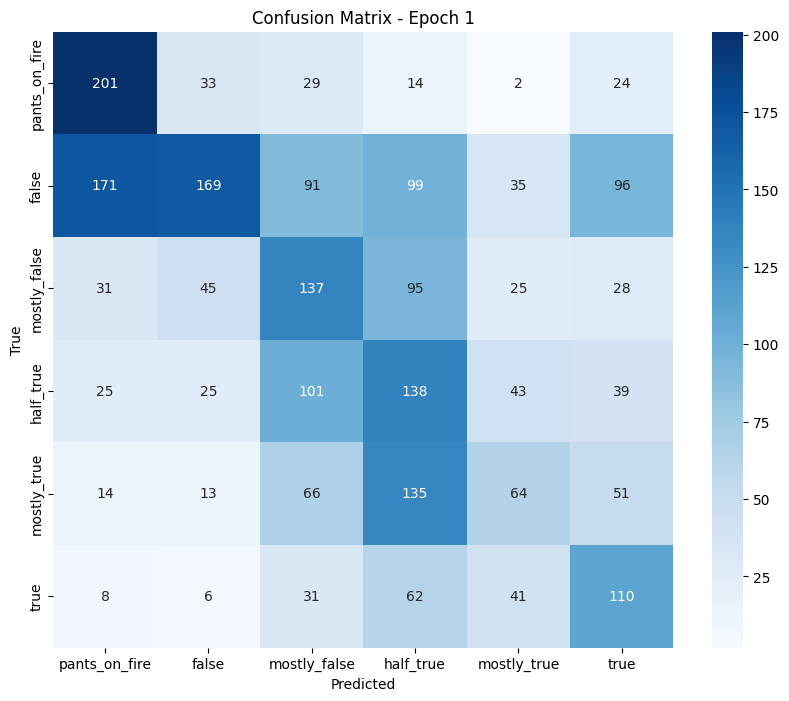

======== Epoch 2 / 15 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 2.3462
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 1.5046
  Validation Accuracy: 0.4930
  Validation F1 (macro): 0.4523

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.53      0.78      0.63       303
        false       0.57      0.49      0.53       661
 mostly_false       0.45      0.44      0.45       361
    half_true       0.56      0.39      0.46       371
  mostly_true       0.58      0.24      0.34       343
         true       0.35      0.72      0.47       258

     accuracy                           0.49      2297
    macro avg       0.51      0.51      0.48      2297
 weighted avg       0.52      0.49      0.48      2297



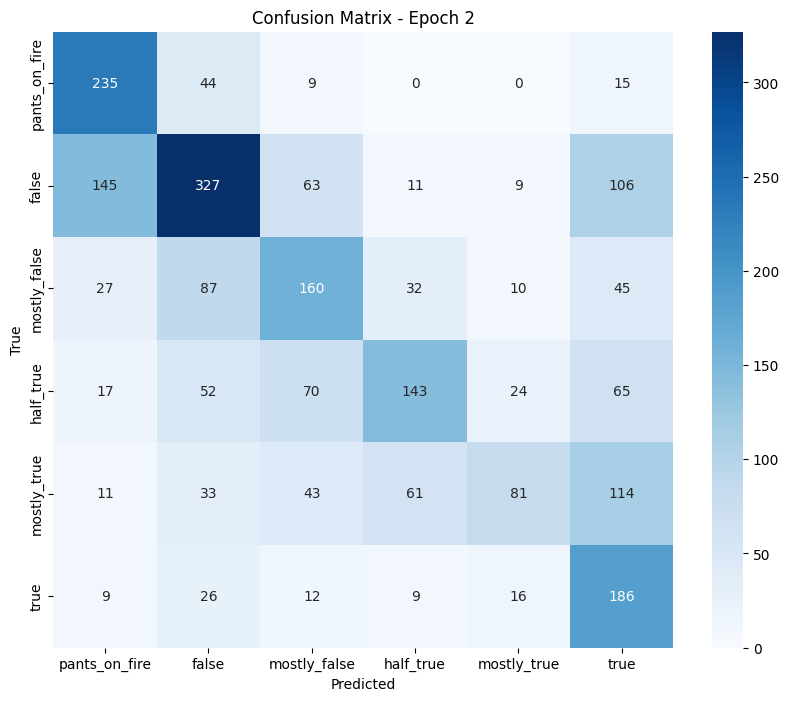

======== Epoch 3 / 15 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 1.6805
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 1.2278
  Validation Accuracy: 0.5840
  Validation F1 (macro): 0.5518

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.74      0.69      0.71       303
        false       0.63      0.63      0.63       661
 mostly_false       0.44      0.61      0.51       361
    half_true       0.63      0.51      0.57       371
  mostly_true       0.53      0.50      0.52       343
         true       0.59      0.52      0.55       258

     accuracy                           0.58      2297
    macro avg       0.59      0.58      0.58      2297
 weighted avg       0.60      0.58      0.59      2297



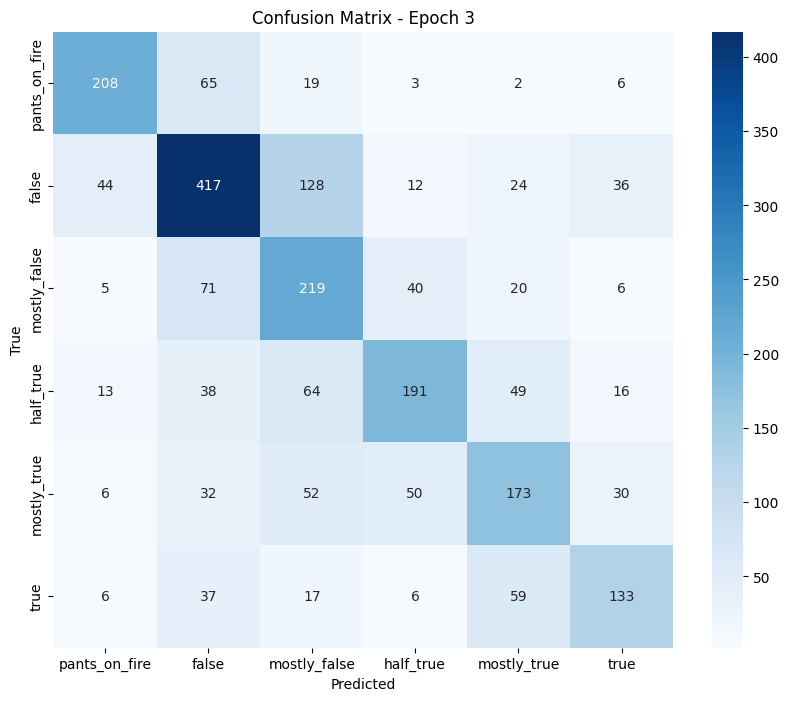

======== Epoch 4 / 15 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 1.3503
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 1.1690
  Validation Accuracy: 0.6025
  Validation F1 (macro): 0.5623

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.86      0.65      0.74       303
        false       0.63      0.68      0.66       661
 mostly_false       0.49      0.53      0.51       361
    half_true       0.59      0.55      0.57       371
  mostly_true       0.51      0.59      0.55       343
         true       0.63      0.54      0.58       258

     accuracy                           0.60      2297
    macro avg       0.62      0.59      0.60      2297
 weighted avg       0.61      0.60      0.60      2297



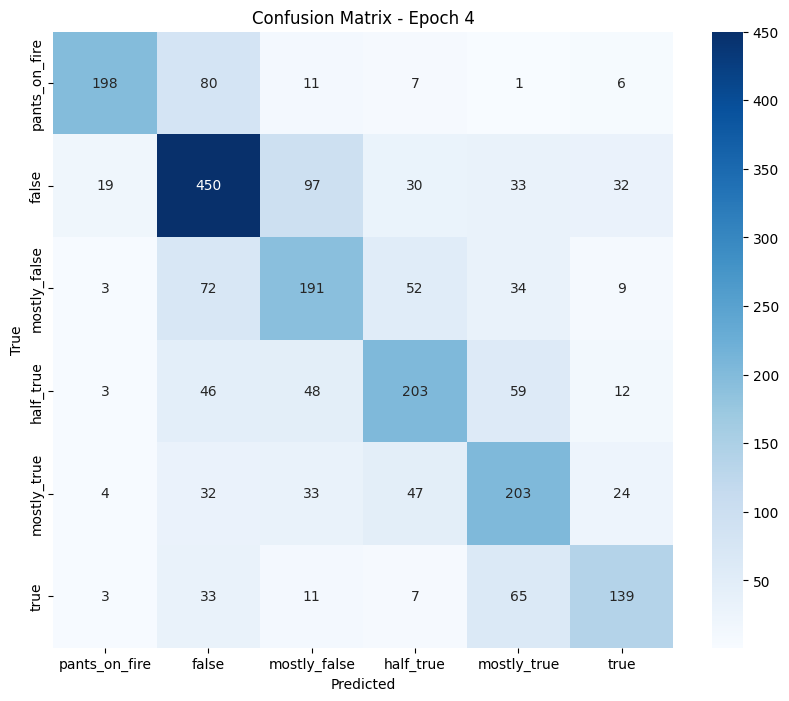

======== Epoch 5 / 15 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 1.1325
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 1.1335
  Validation Accuracy: 0.6139
  Validation F1 (macro): 0.5724

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.79      0.70      0.74       303
        false       0.64      0.71      0.67       661
 mostly_false       0.75      0.39      0.51       361
    half_true       0.50      0.69      0.58       371
  mostly_true       0.69      0.42      0.52       343
         true       0.49      0.73      0.59       258

     accuracy                           0.61      2297
    macro avg       0.64      0.61      0.60      2297
 weighted avg       0.64      0.61      0.61      2297



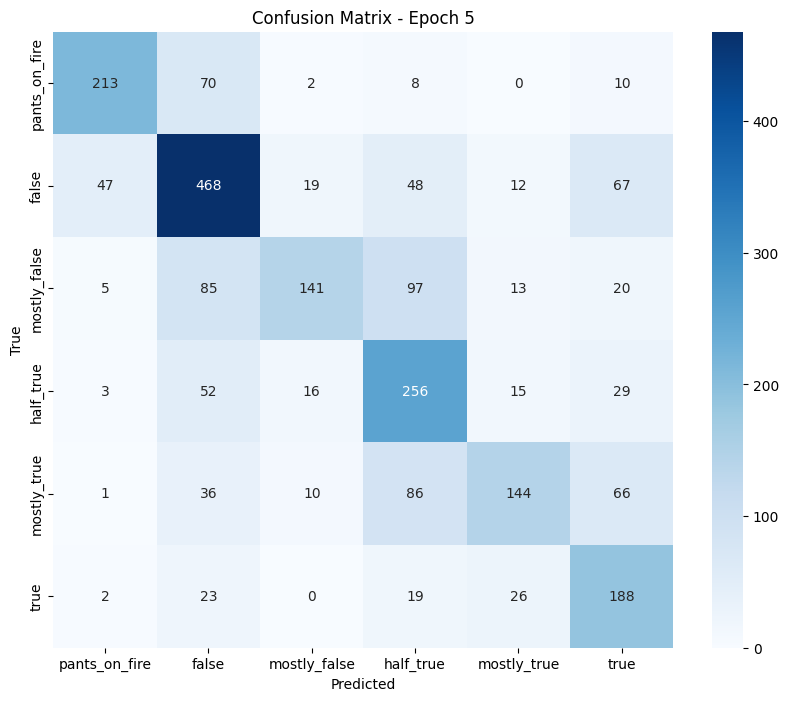

======== Epoch 6 / 15 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 0.9731
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 1.1825
  Validation Accuracy: 0.6123
  Validation F1 (macro): 0.5734

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.65      0.78      0.71       303
        false       0.61      0.67      0.64       661
 mostly_false       0.62      0.45      0.52       361
    half_true       0.58      0.62      0.60       371
  mostly_true       0.66      0.48      0.56       343
         true       0.57      0.65      0.61       258

     accuracy                           0.61      2297
    macro avg       0.61      0.61      0.61      2297
 weighted avg       0.61      0.61      0.61      2297



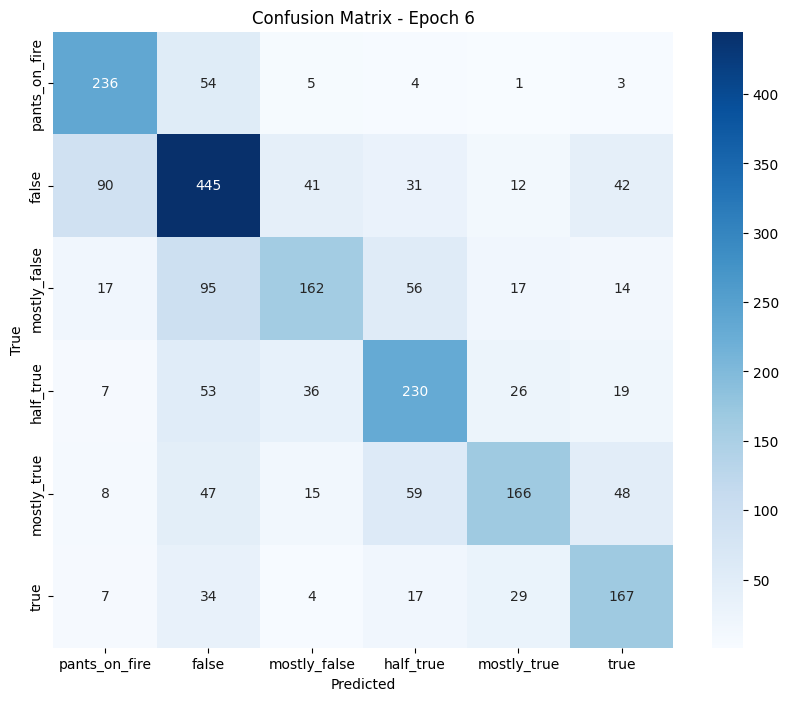

======== Epoch 7 / 15 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 0.8551
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 1.1725
  Validation Accuracy: 0.5982
  Validation F1 (macro): 0.5667

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.86      0.68      0.76       303
        false       0.69      0.60      0.64       661
 mostly_false       0.53      0.49      0.51       361
    half_true       0.51      0.63      0.56       371
  mostly_true       0.55      0.54      0.54       343
         true       0.50      0.68      0.58       258

     accuracy                           0.60      2297
    macro avg       0.60      0.60      0.60      2297
 weighted avg       0.61      0.60      0.60      2297



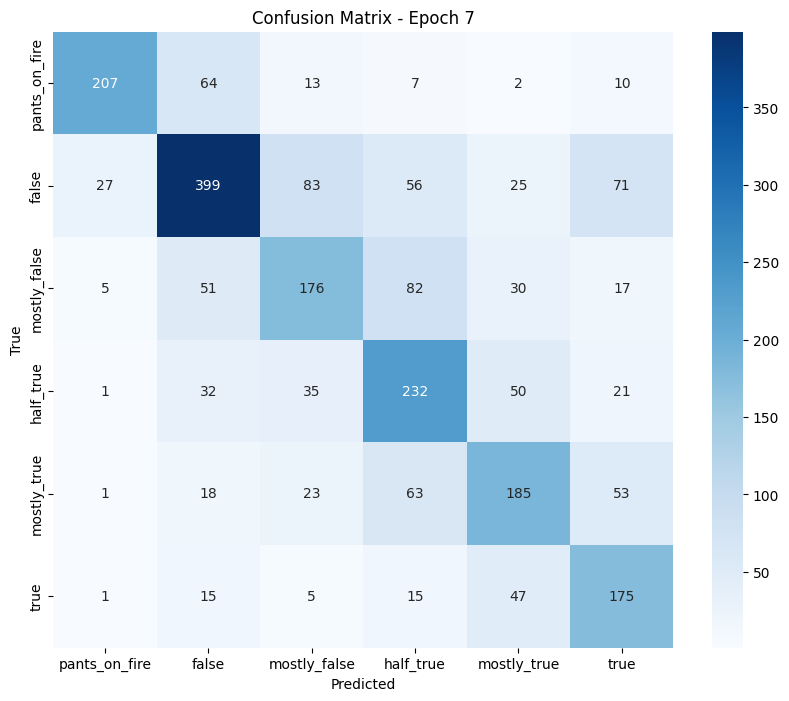

======== Epoch 8 / 15 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 0.7426
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 1.1850
  Validation Accuracy: 0.6009
  Validation F1 (macro): 0.5638

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.77      0.72      0.75       303
        false       0.69      0.61      0.65       661
 mostly_false       0.66      0.38      0.48       361
    half_true       0.47      0.68      0.55       371
  mostly_true       0.58      0.55      0.56       343
         true       0.51      0.70      0.59       258

     accuracy                           0.60      2297
    macro avg       0.61      0.61      0.60      2297
 weighted avg       0.62      0.60      0.60      2297



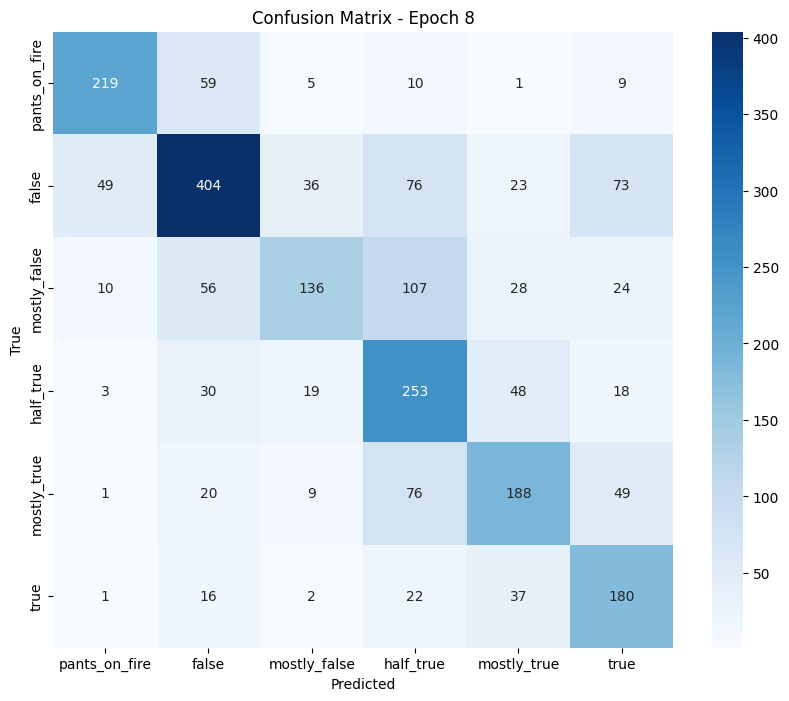

======== Epoch 9 / 15 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 0.6581
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 1.1835
  Validation Accuracy: 0.6032
  Validation F1 (macro): 0.5710

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.76      0.73      0.74       303
        false       0.67      0.61      0.64       661
 mostly_false       0.50      0.48      0.49       361
    half_true       0.54      0.63      0.58       371
  mostly_true       0.57      0.53      0.55       343
         true       0.56      0.66      0.61       258

     accuracy                           0.60      2297
    macro avg       0.60      0.61      0.60      2297
 weighted avg       0.61      0.60      0.60      2297



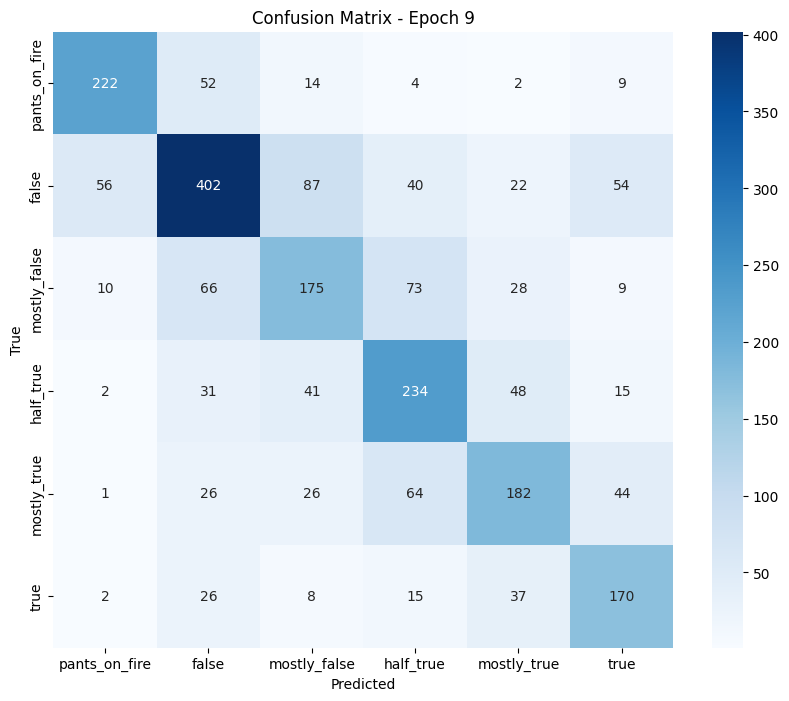

======== Epoch 10 / 15 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 0.5876
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 1.2139
  Validation Accuracy: 0.6096
  Validation F1 (macro): 0.5765

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.80      0.71      0.75       303
        false       0.66      0.62      0.64       661
 mostly_false       0.50      0.52      0.51       361
    half_true       0.61      0.56      0.59       371
  mostly_true       0.56      0.58      0.57       343
         true       0.54      0.69      0.61       258

     accuracy                           0.61      2297
    macro avg       0.61      0.61      0.61      2297
 weighted avg       0.62      0.61      0.61      2297



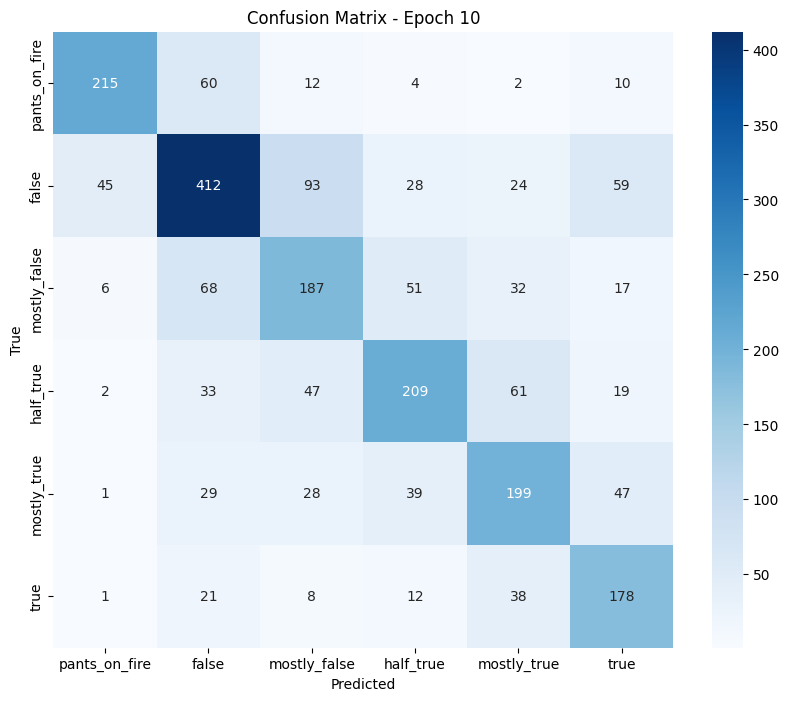

======== Epoch 11 / 15 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 0.5347
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 1.2517
  Validation Accuracy: 0.5992
  Validation F1 (macro): 0.5657

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.78      0.73      0.75       303
        false       0.68      0.58      0.63       661
 mostly_false       0.49      0.51      0.50       361
    half_true       0.57      0.58      0.58       371
  mostly_true       0.54      0.57      0.55       343
         true       0.53      0.69      0.60       258

     accuracy                           0.60      2297
    macro avg       0.60      0.61      0.60      2297
 weighted avg       0.61      0.60      0.60      2297



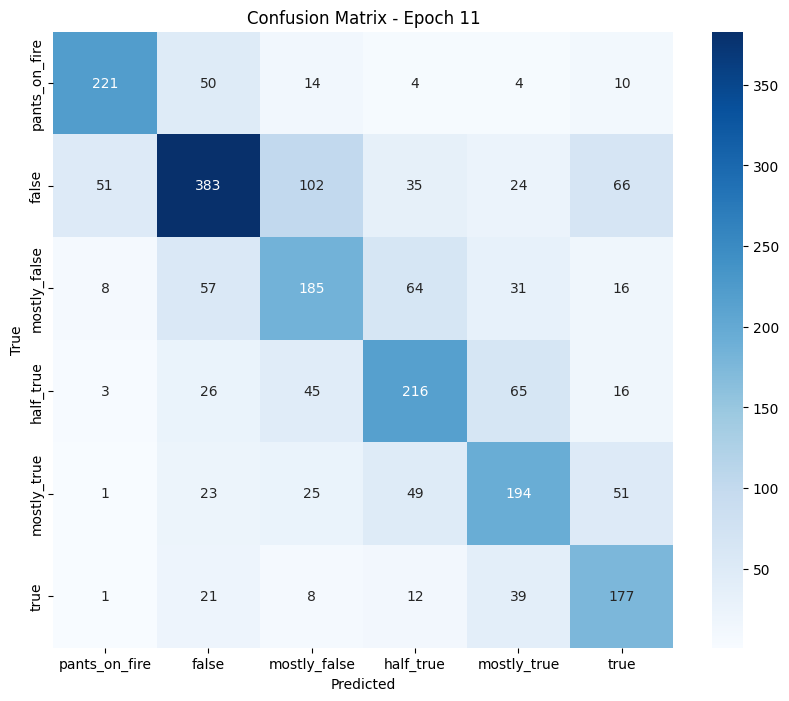

======== Epoch 12 / 15 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 0.4983
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 1.2729
  Validation Accuracy: 0.6120
  Validation F1 (macro): 0.5778

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.79      0.71      0.75       303
        false       0.65      0.64      0.65       661
 mostly_false       0.50      0.51      0.51       361
    half_true       0.56      0.64      0.60       371
  mostly_true       0.59      0.53      0.56       343
         true       0.58      0.64      0.61       258

     accuracy                           0.61      2297
    macro avg       0.61      0.61      0.61      2297
 weighted avg       0.62      0.61      0.61      2297



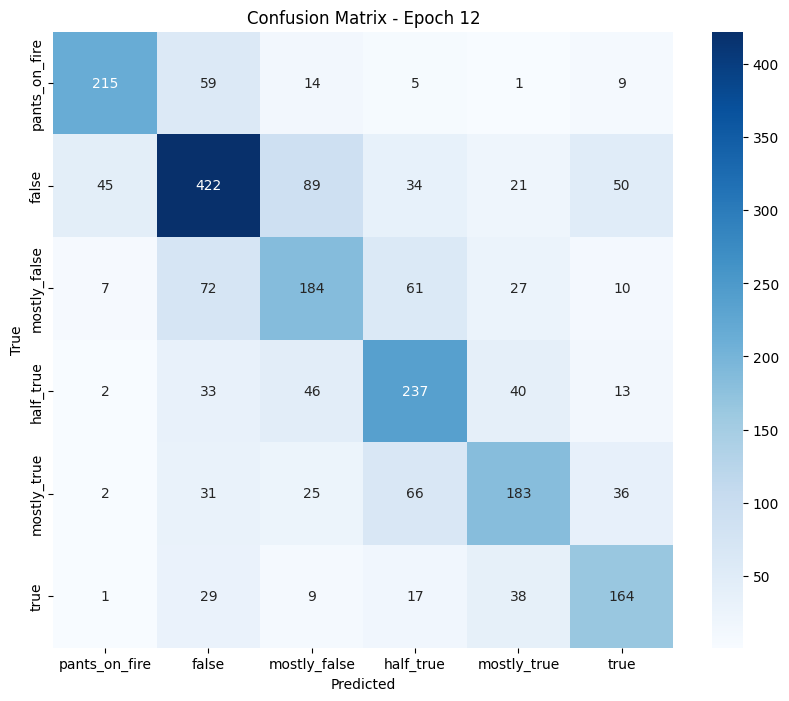

======== Epoch 13 / 15 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 0.4646
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 1.2767
  Validation Accuracy: 0.6052
  Validation F1 (macro): 0.5696

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.75      0.74      0.74       303
        false       0.65      0.62      0.64       661
 mostly_false       0.54      0.49      0.51       361
    half_true       0.57      0.60      0.58       371
  mostly_true       0.57      0.53      0.55       343
         true       0.53      0.68      0.59       258

     accuracy                           0.61      2297
    macro avg       0.60      0.61      0.60      2297
 weighted avg       0.61      0.61      0.60      2297



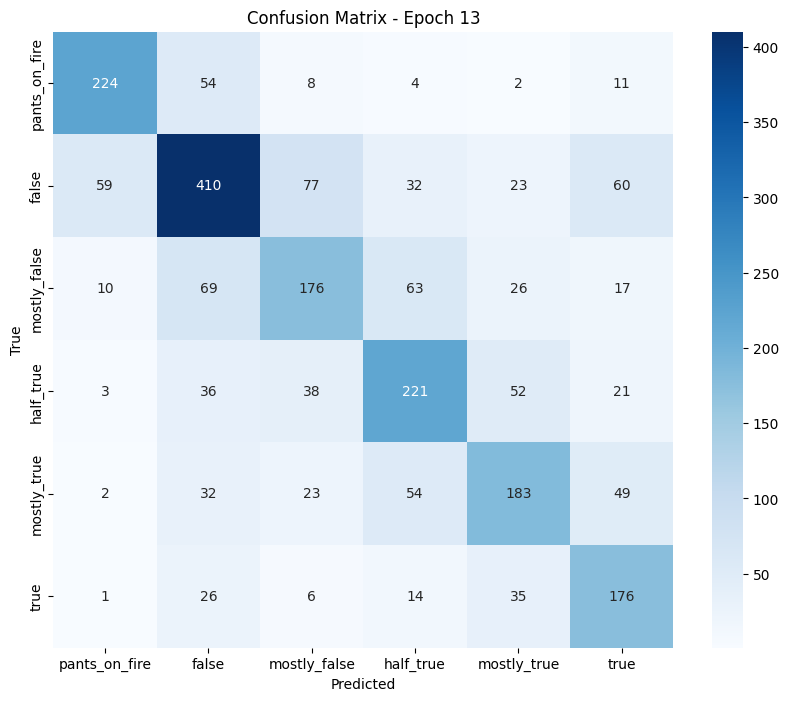

======== Epoch 14 / 15 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 0.4593
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 1.2862
  Validation Accuracy: 0.6064
  Validation F1 (macro): 0.5722

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.76      0.74      0.75       303
        false       0.65      0.63      0.64       661
 mostly_false       0.54      0.48      0.51       361
    half_true       0.56      0.62      0.59       371
  mostly_true       0.58      0.52      0.55       343
         true       0.54      0.67      0.60       258

     accuracy                           0.61      2297
    macro avg       0.60      0.61      0.60      2297
 weighted avg       0.61      0.61      0.61      2297



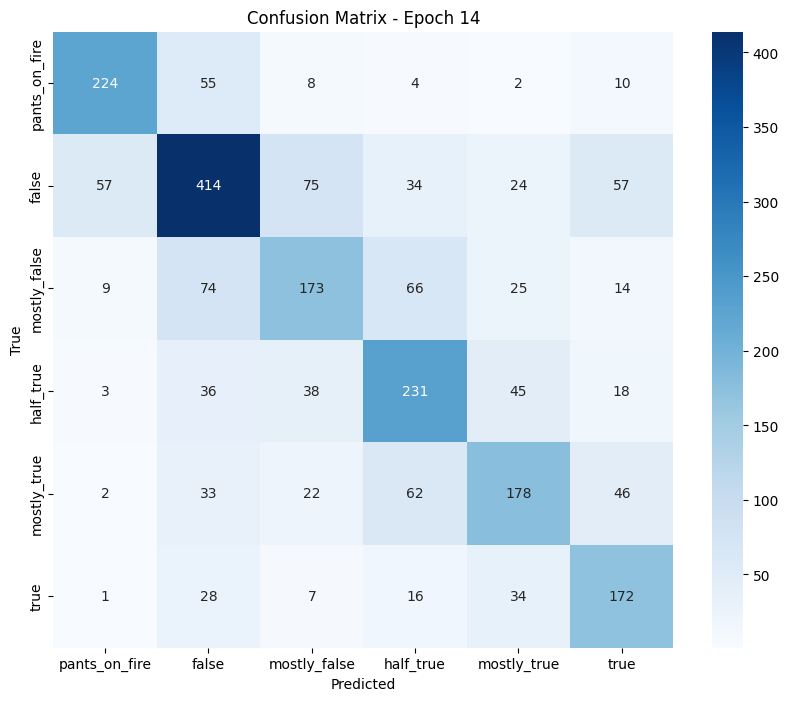

======== Epoch 15 / 15 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 0.4589
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 1.2842
  Validation Accuracy: 0.6072
  Validation F1 (macro): 0.5721

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.75      0.75      0.75       303
        false       0.66      0.62      0.64       661
 mostly_false       0.52      0.49      0.51       361
    half_true       0.57      0.62      0.59       371
  mostly_true       0.58      0.52      0.55       343
         true       0.54      0.66      0.60       258

     accuracy                           0.61      2297
    macro avg       0.60      0.61      0.61      2297
 weighted avg       0.61      0.61      0.61      2297



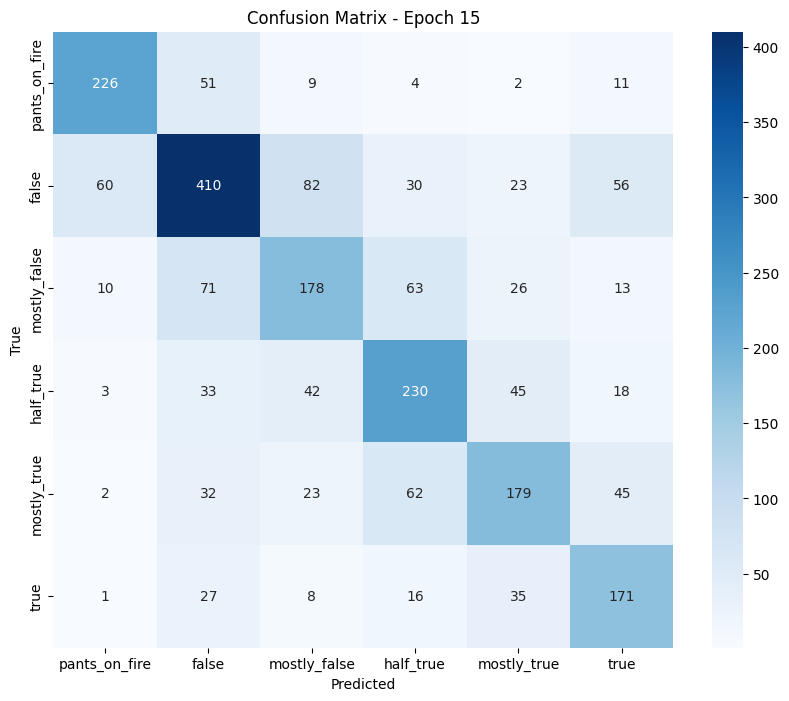

Training complete!


In [35]:
# Train the model
print("Starting model training...")
model, train_loss_values, val_loss_values = train_model(
    model, 
    train_dataloader, 
    val_dataloader, 
    optimizer, 
    scheduler, 
    epochs=epochs,
    accumulation_steps=accumulation_steps
)

## Training and Validation Loss Analysis

Let's visualize how the loss changed during training to check for signs of overfitting.

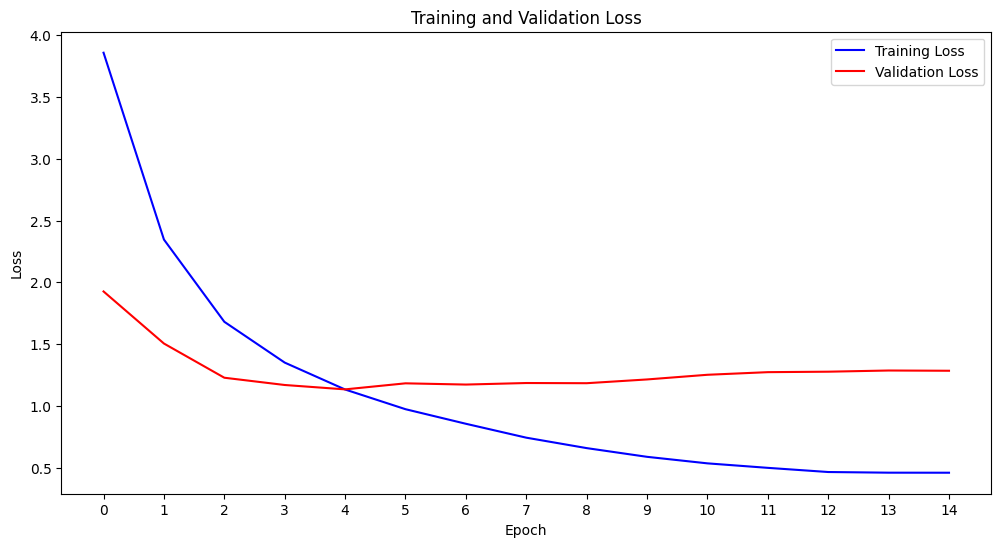

In [36]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss_values, 'b-', label='Training Loss')
plt.plot(val_loss_values, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(range(len(train_loss_values)))
plt.show()

## Test Set Evaluation

Now I'll evaluate how well the model generalizes to unseen data using the test set.

In [37]:
# Evaluate the model on the test set
print("Evaluating model on test set...")
model.eval()

Evaluating model on test set...


EnhancedTinyBertForFakeNews(
  (tinybert): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 312, padding_idx=0)
        (position_embeddings): Embedding(512, 312)
        (token_type_embeddings): Embedding(2, 312)
        (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-3): 4 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=312, out_features=312, bias=True)
                (key): Linear(in_features=312, out_features=312, bias=True)
                (value): Linear(in_features=312, out_features=312, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=312,

In [38]:
# Tracking variables
test_loss = 0
test_accuracy = 0
test_f1 = 0
nb_test_steps = 0

In [39]:
all_preds = []
all_labels = []

In [40]:
# Evaluate data
for batch in tqdm(test_dataloader):
    # Unpack the test batch
    has_justification = hasattr(model, 'justification_bert') and model.has_justification
    has_numerical = hasattr(model, 'numerical_linear1') and model.has_numerical
    
    b_input_ids = batch[0].to(device)
    b_attention_mask = batch[1].to(device)
    
    batch_idx = 2
    b_just_ids = None
    b_just_mask = None
    b_numerical = None
    
    if has_justification:
        b_just_ids = batch[batch_idx].to(device)
        b_just_mask = batch[batch_idx + 1].to(device)
        batch_idx += 2
    
    if has_numerical:
        b_numerical = batch[batch_idx].to(device)
        batch_idx += 1
    
    b_labels = batch[batch_idx].to(device)
    
    with torch.no_grad():        
        # Forward pass
        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_attention_mask,
            just_ids=b_just_ids,
            just_mask=b_just_mask,
            numerical_features=b_numerical,
            labels=b_labels
        )
        
        loss = outputs["loss"]
        logits = outputs["logits"]
        
        # Accumulate the test loss
        test_loss += loss.item()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy
        tmp_test_accuracy = flat_accuracy(logits, label_ids)
        
        # Calculate the F1 score
        tmp_test_f1 = flat_f1(logits, label_ids)
        
        # Store predictions and labels
        preds = np.argmax(logits, axis=1).flatten()
        all_preds.extend(preds)
        all_labels.extend(label_ids.flatten())
        
        # Accumulate metrics
        test_accuracy += tmp_test_accuracy
        test_f1 += tmp_test_f1
        
        # Track the number of batches
        nb_test_steps += 1

  0%|          | 0/72 [00:00<?, ?it/s]

In [41]:
# Report the final accuracy for the test set
avg_test_loss = test_loss / len(test_dataloader)
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy/nb_test_steps:.4f}")
print(f"  Test F1 (macro): {test_f1/nb_test_steps:.4f}")

  Test Loss: 1.1904
  Test Accuracy: 0.6325
  Test F1 (macro): 0.5989


In [42]:
# Print classification report
print("\nFinal Classification Report:")
print(classification_report(all_labels, all_preds, target_names=list(label_mapping.values())))


Final Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.70      0.77      0.73       303
        false       0.70      0.65      0.67       660
 mostly_false       0.56      0.56      0.56       360
    half_true       0.57      0.56      0.56       371
  mostly_true       0.61      0.54      0.57       343
         true       0.61      0.75      0.67       259

     accuracy                           0.63      2296
    macro avg       0.62      0.64      0.63      2296
 weighted avg       0.63      0.63      0.63      2296



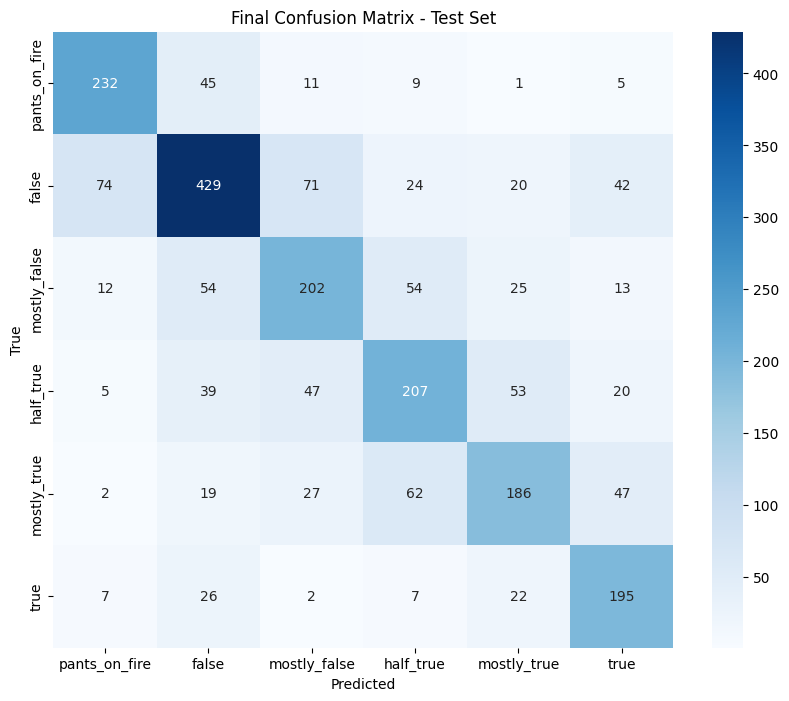

In [43]:
# Plot the final confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_mapping.values()),
            yticklabels=list(label_mapping.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Final Confusion Matrix - Test Set')
plt.show()

## Analysis by Source and Speaker

Let's examine how the model performs on statements from different speakers and sources to identify potential biases or strengths.

In [44]:
# Get the test predictions
test_predictions = all_preds

In [45]:
# Add predictions to the test dataframe
test_df['prediction'] = test_predictions

In [46]:
# Performance by speaker
top_speakers = test_df['speaker'].value_counts().head(10).index
speaker_performance = {}

In [47]:
for speaker in top_speakers:
    speaker_df = test_df[test_df['speaker'] == speaker]
    speaker_acc = accuracy_score(speaker_df['label'], speaker_df['prediction'])
    speaker_f1 = f1_score(speaker_df['label'], speaker_df['prediction'], average='macro')
    speaker_performance[speaker] = {'accuracy': speaker_acc, 'f1': speaker_f1, 'count': len(speaker_df)}

In [48]:
# Display speaker performance
speaker_perf_df = pd.DataFrame.from_dict(speaker_performance, orient='index')
print("\nPerformance by Top 10 Speakers:")
print(speaker_perf_df.sort_values('count', ascending=False))


Performance by Top 10 Speakers:
                 accuracy        f1  count
facebook posts   0.836066  0.533900    244
viral image      0.885965  0.622808    114
donald trump     0.434783  0.436844     92
bloggers         0.647887  0.412204     71
barack obama     0.523810  0.372202     63
instagram posts  0.860000  0.428468     50
joe biden        0.678571  0.700712     28
rick scott       0.500000  0.472251     26
hillary clinton  0.560000  0.391667     25
scott walker     0.680000  0.711111     25


<Figure size 1400x700 with 0 Axes>

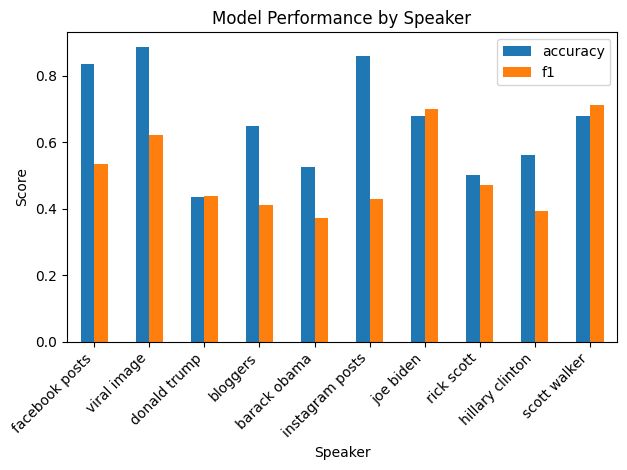

In [49]:
# Plot speaker performance
plt.figure(figsize=(14, 7))
speaker_perf_df.sort_values('count', ascending=False)[['accuracy', 'f1']].plot(kind='bar')
plt.title('Model Performance by Speaker')
plt.xlabel('Speaker')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

## Speaker-Based Calibration

I'll try to improve predictions by calibrating them based on speaker reliability patterns observed in training data.

In [50]:
# Calculate speaker reliability from training data
speaker_reliability = {}
for speaker in train_df['speaker'].unique():
    speaker_data = train_df[train_df['speaker'] == speaker]
    if len(speaker_data) >= 10:  # Only consider speakers with enough data
        # Calculate average truthfulness (higher label = more true)
        avg_truth = speaker_data['label'].mean() / 5.0  # Normalize to 0-1
        speaker_reliability[speaker] = avg_truth

# Apply speaker-based calibration to predictions
def calibrate_prediction(pred_probs, speaker):
    if speaker in speaker_reliability:
        # Adjust probabilities based on speaker reliability
        reliability = speaker_reliability[speaker]
        
        # Boost true-leaning predictions for reliable speakers
        if reliability > 0.5:
            boost_factor = (reliability - 0.5) * 2  # Scale to 0-1
            # Boost higher truth categories
            pred_probs[3:] *= (1 + boost_factor * 0.2)
        # Boost false-leaning predictions for unreliable speakers
        else:
            boost_factor = (0.5 - reliability) * 2  # Scale to 0-1
            # Boost lower truth categories
            pred_probs[:3] *= (1 + boost_factor * 0.2)
            
        # Normalize probabilities
        pred_probs /= pred_probs.sum()
        
    return pred_probs

Applying speaker-based calibration to predictions...


  0%|          | 0/72 [00:00<?, ?it/s]

Original Test Accuracy: 0.6325
Calibrated Test Accuracy: 0.6302
Original Test F1 (macro): 0.5989
Calibrated Test F1 (macro): 0.6274

Calibrated Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.70      0.77      0.73       303
        false       0.70      0.65      0.67       660
 mostly_false       0.56      0.56      0.56       360
    half_true       0.57      0.55      0.56       371
  mostly_true       0.60      0.54      0.57       343
         true       0.60      0.75      0.67       259

     accuracy                           0.63      2296
    macro avg       0.62      0.64      0.63      2296
 weighted avg       0.63      0.63      0.63      2296



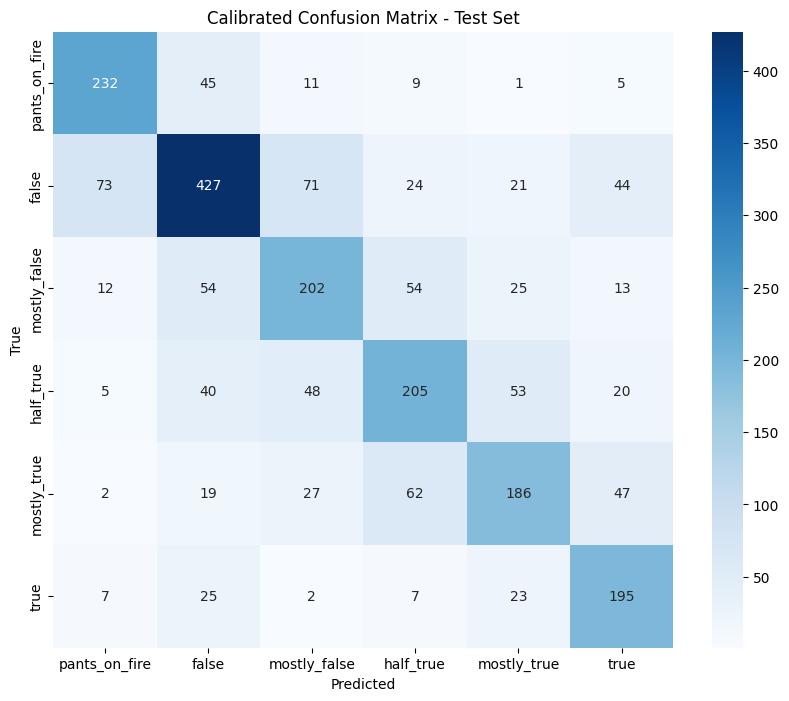

In [51]:
# Apply calibration to predictions
print("Applying speaker-based calibration to predictions...")

# Get logits from model for test data
model.eval()
calibrated_preds = []

for batch in tqdm(test_dataloader):
    # Same unpacking logic as in train_model 
    has_justification = hasattr(model, 'justification_bert') and model.has_justification
    has_numerical = hasattr(model, 'numerical_linear1') and model.has_numerical
    
    b_input_ids = batch[0].to(device)
    b_attention_mask = batch[1].to(device)
    
    batch_idx = 2
    b_just_ids = None
    b_just_mask = None
    b_numerical = None
    
    if has_justification:
        b_just_ids = batch[batch_idx].to(device)
        b_just_mask = batch[batch_idx + 1].to(device)
        batch_idx += 2
    
    if has_numerical:
        b_numerical = batch[batch_idx].to(device)
        batch_idx += 1
    
    with torch.no_grad():
        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_attention_mask,
            just_ids=b_just_ids,
            just_mask=b_just_mask,
            numerical_features=b_numerical
        )
        
        # Get probabilities
        logits = outputs["logits"]
        probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
        
        # Get corresponding speakers for this batch
        batch_indices = list(range(len(calibrated_preds), len(calibrated_preds) + len(probs)))
        batch_speakers = test_df.iloc[batch_indices]['speaker'].values
        
        # Apply calibration
        for i, (prob, speaker) in enumerate(zip(probs, batch_speakers)):
            calibrated_prob = calibrate_prediction(prob, speaker)
            calibrated_pred = np.argmax(calibrated_prob)
            calibrated_preds.append(calibrated_pred)

# Calculate metrics with calibrated predictions
calibrated_accuracy = accuracy_score(all_labels, calibrated_preds)
calibrated_f1 = f1_score(all_labels, calibrated_preds, average='macro')

print(f"Original Test Accuracy: {test_accuracy/nb_test_steps:.4f}")
print(f"Calibrated Test Accuracy: {calibrated_accuracy:.4f}")
print(f"Original Test F1 (macro): {test_f1/nb_test_steps:.4f}")
print(f"Calibrated Test F1 (macro): {calibrated_f1:.4f}")

# Print classification report for calibrated predictions
print("\nCalibrated Classification Report:")
print(classification_report(all_labels, calibrated_preds, target_names=list(label_mapping.values())))

# Plot confusion matrix for calibrated predictions
cm_calibrated = confusion_matrix(all_labels, calibrated_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_calibrated, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_mapping.values()),
            yticklabels=list(label_mapping.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Calibrated Confusion Matrix - Test Set')
plt.show()

In [52]:
# Save the model and tokenizer
output_dir = './model_save/'
os.makedirs(output_dir, exist_ok=True)

print(f"Saving model to {output_dir}")
# Save tokenizer
tokenizer.save_pretrained(output_dir)
# For custom model, save the state dict
torch.save(model.state_dict(), os.path.join(output_dir, "pytorch_model.bin"))

print("Completed!")

Saving model to ./model_save/
Completed!


## Conclusion

The model achieved 63.25% accuracy and a macro F1 score of 0.5989 on the test set. It performed best on extreme categories ("pants_on_fire" and "true") but struggled more with nuanced categories like "mostly_false".

Social media content was easier to classify than statements from politicians, suggesting source-based patterns. The calibration approach showed minimal improvement, indicating the model already captured speaker credibility well.